# Testing the 4 assumptions of multiple regression

4 assumptions need to be checked:
1. Linearity
2. Normality 
3. Homoscedasticity 
4. Independence of errors

If these assumptions are violated, it can impact the validity of our results. However, a balance between these assumptions being met and the complexity of the real-world relationships must be striked to enhance the validity of our findings and to provide reliable and intepretable regression models. It thus must be understood that sometimes a certain level of assumptions' violation can be accepted as real-world scenarios are unlikely to adhere strictly to all assumptions. 


# Loading file and necessary libraries

In [1]:
%%capture
!pip install geopandas

In [3]:
import requests
import pandas as pd
import textwrap
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import matplotlib.colors as colors
import warnings
import plotly.graph_objects as go
import geopandas as gpd
from IPython.core.interactiveshell import InteractiveShell
import numpy as np
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, davies_bouldin_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.datasets import make_regression
from statsmodels.tsa.arima_process import ArmaProcess
from scipy.spatial.distance import cdist
from numpy.random import default_rng
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

InteractiveShell.ast_node_interactivity = "all"
%autosave 120

Autosaving every 120 seconds


In [4]:
df_final=pd.read_csv('/project/df_final.csv')

In [5]:
df_final.columns

Index(['GeoName', 'Year', 'Total_population', 'Total_households',
       'Female_population', 'Male_population', 'Median_age',
       'Median_household_income_past_12m', 'Bachelor_degree', 'Master_degree',
       'Professional_degree', 'Doctorate_degree', 'Num_employed',
       'Num_unemployed', 'Labor_force', 'Avg_household_size',
       'Median_value_owner_occupied_housing', 'Households_solar_energy_fuel',
       'Num_under_18', 'Num_18_to_34', 'Num_35_to_64', 'Num_65_more',
       'Num_industry_agriculture_fishing_hunting', 'consensus',
       'consensusOppose', 'futuregen', 'futuregenOppose', 'happening',
       'happeningOppose', 'harmUS', 'harmUSOppose', 'human', 'humanOppose',
       'personal', 'personalOppose', 'regulate', 'regulateOppose', 'timing',
       'timingOppose', 'worried', 'worriedOppose',
       'Average_Temperature_per_Year', 'Average_Precipitation_per_Year',
       'Average_PDSI_per_Year', 'Region', 'Price_per_unit_thousands_USD',
       'Volume_California_Millio

# Data preparation

We are dropping some variables that we don't believe are necessary. First, as we are focusing on California as a state, we do not need to keep the columns Region, and GeoName. Moreover, studies have not been able to find correlations between variables such as precipitation and PDSI and environmental consicousness or green purchase intention. Hence these variables will be dropped. Last, as we are keeping the revenue in USD of washing machines, we will drop the volume as these variables will have extremely high multicollinearity. 

In [6]:
df_final.drop(columns=['Region','GeoName','Average_Precipitation_per_Year','Average_PDSI_per_Year','Volume_California_Million_Pieces'],inplace=True)

The variable year is changed to become the index

In [7]:
df_final['Year'] = pd.to_datetime(df_final['Year'], format='%Y')

df_final.set_index('Year', inplace=True)

Multicollinearity will be a problem, thus we are looking at how we can reduce this by combining some variables

In [8]:
df_final['Higher_degree']=df_final['Bachelor_degree']+df_final['Master_degree']+df_final['Professional_degree']+df_final['Doctorate_degree']
df_final.drop(columns=['Bachelor_degree', 'Master_degree', 'Professional_degree',
       'Doctorate_degree'],inplace=True)

All the consensus and consensusOppose etc... are obviously highly correlated. while consensus != 1 - consensusOppose because some people refused to answer, that percentage is small (back it up with graphs). Thus, instead we will replace these variables with ratios that represent the ratio between the people that believe and oppose the belief.  

In [9]:
# Create ratio variables
df_final['futuregen_ratio'] = df_final['futuregen'] / df_final['futuregenOppose']
df_final['consensus_ratio'] = df_final['consensus'] / df_final['consensusOppose']
df_final['happening_ratio'] = df_final['happening'] /df_final['happeningOppose']
df_final['harmUS_ratio'] = df_final['harmUS'] / df_final['harmUSOppose']
df_final['human_ratio'] = df_final['human'] / df_final['humanOppose']
df_final['personal_ratio'] = df_final['personal'] / df_final['personalOppose']
df_final['regulate_ratio'] = df_final['regulate'] / df_final['regulateOppose']
df_final['timing_ratio'] = df_final['timing'] / df_final['timingOppose']
df_final['worried_ratio'] = df_final['worried'] / df_final['worriedOppose']


In [10]:
df_final.drop(columns=['futuregen','futuregenOppose','consensus','consensusOppose',
                    'happening','happeningOppose','harmUS','harmUSOppose','human','humanOppose',
                       'personal','personalOppose','regulate','regulateOppose',
                       'timing','timingOppose','worried','worriedOppose']
    #all the values transformed in ratios
                  ,inplace=True)

## Standardization

We standardize the data before checking the regression assumptions to make the variables comparable, allowing for a more meaning representation of the data. Plus, it helps to identify significant outliers and it simplies diagnostics.

In [11]:
# Extract the index
index = df_final.index

df_X = df_final.drop('Revenue_California_Billion_USD', axis=1) 
df_y = df_final['Revenue_California_Billion_USD']

# Create a separate scaler object for X and y
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Standardize X and y
df_X_scaled = pd.DataFrame(scaler_X.fit_transform(df_X), columns=df_X.columns)
df_y_scaled = pd.DataFrame(scaler_y.fit_transform(df_y.values.reshape(-1,1)), columns=['Revenue_California_Billion_USD'])

# Restore the index
df_X_scaled.index = index
df_y_scaled.index = index

review VIF

In [12]:
# Split the scaled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_X_scaled,df_y_scaled, test_size=0.2, random_state=13)

Before testing the four assumptions, we will change the variable of revenue on a county level to be aligned with the demographic and survey variables. However, the temperature variable will be on a state level only. 

In [13]:
# Calculate the sum of population for each year
yearly_population_sum = df_final.groupby(level='Year')['Total_population'].sum()

# Calculate the revenue by county
df_final['Revenue_by_county_Million'] = (df_final['Revenue_California_Billion_USD'] / yearly_population_sum) * df_final['Total_population'] * 1000
df_final.drop(columns=['Revenue_California_Billion_USD'],inplace=True)

# Testing the 4 assumptions

## Assumption: Linearity

In [14]:
# Specify the dependent and independent variables
predictor_vars = df_final.drop(columns=['Revenue_by_county_Million']).columns.tolist()
response_var = 'Revenue_by_county_Million'
# Group by year and calculate the average 
df_grouped = df_final.groupby('Year')[predictor_vars].mean().reset_index()

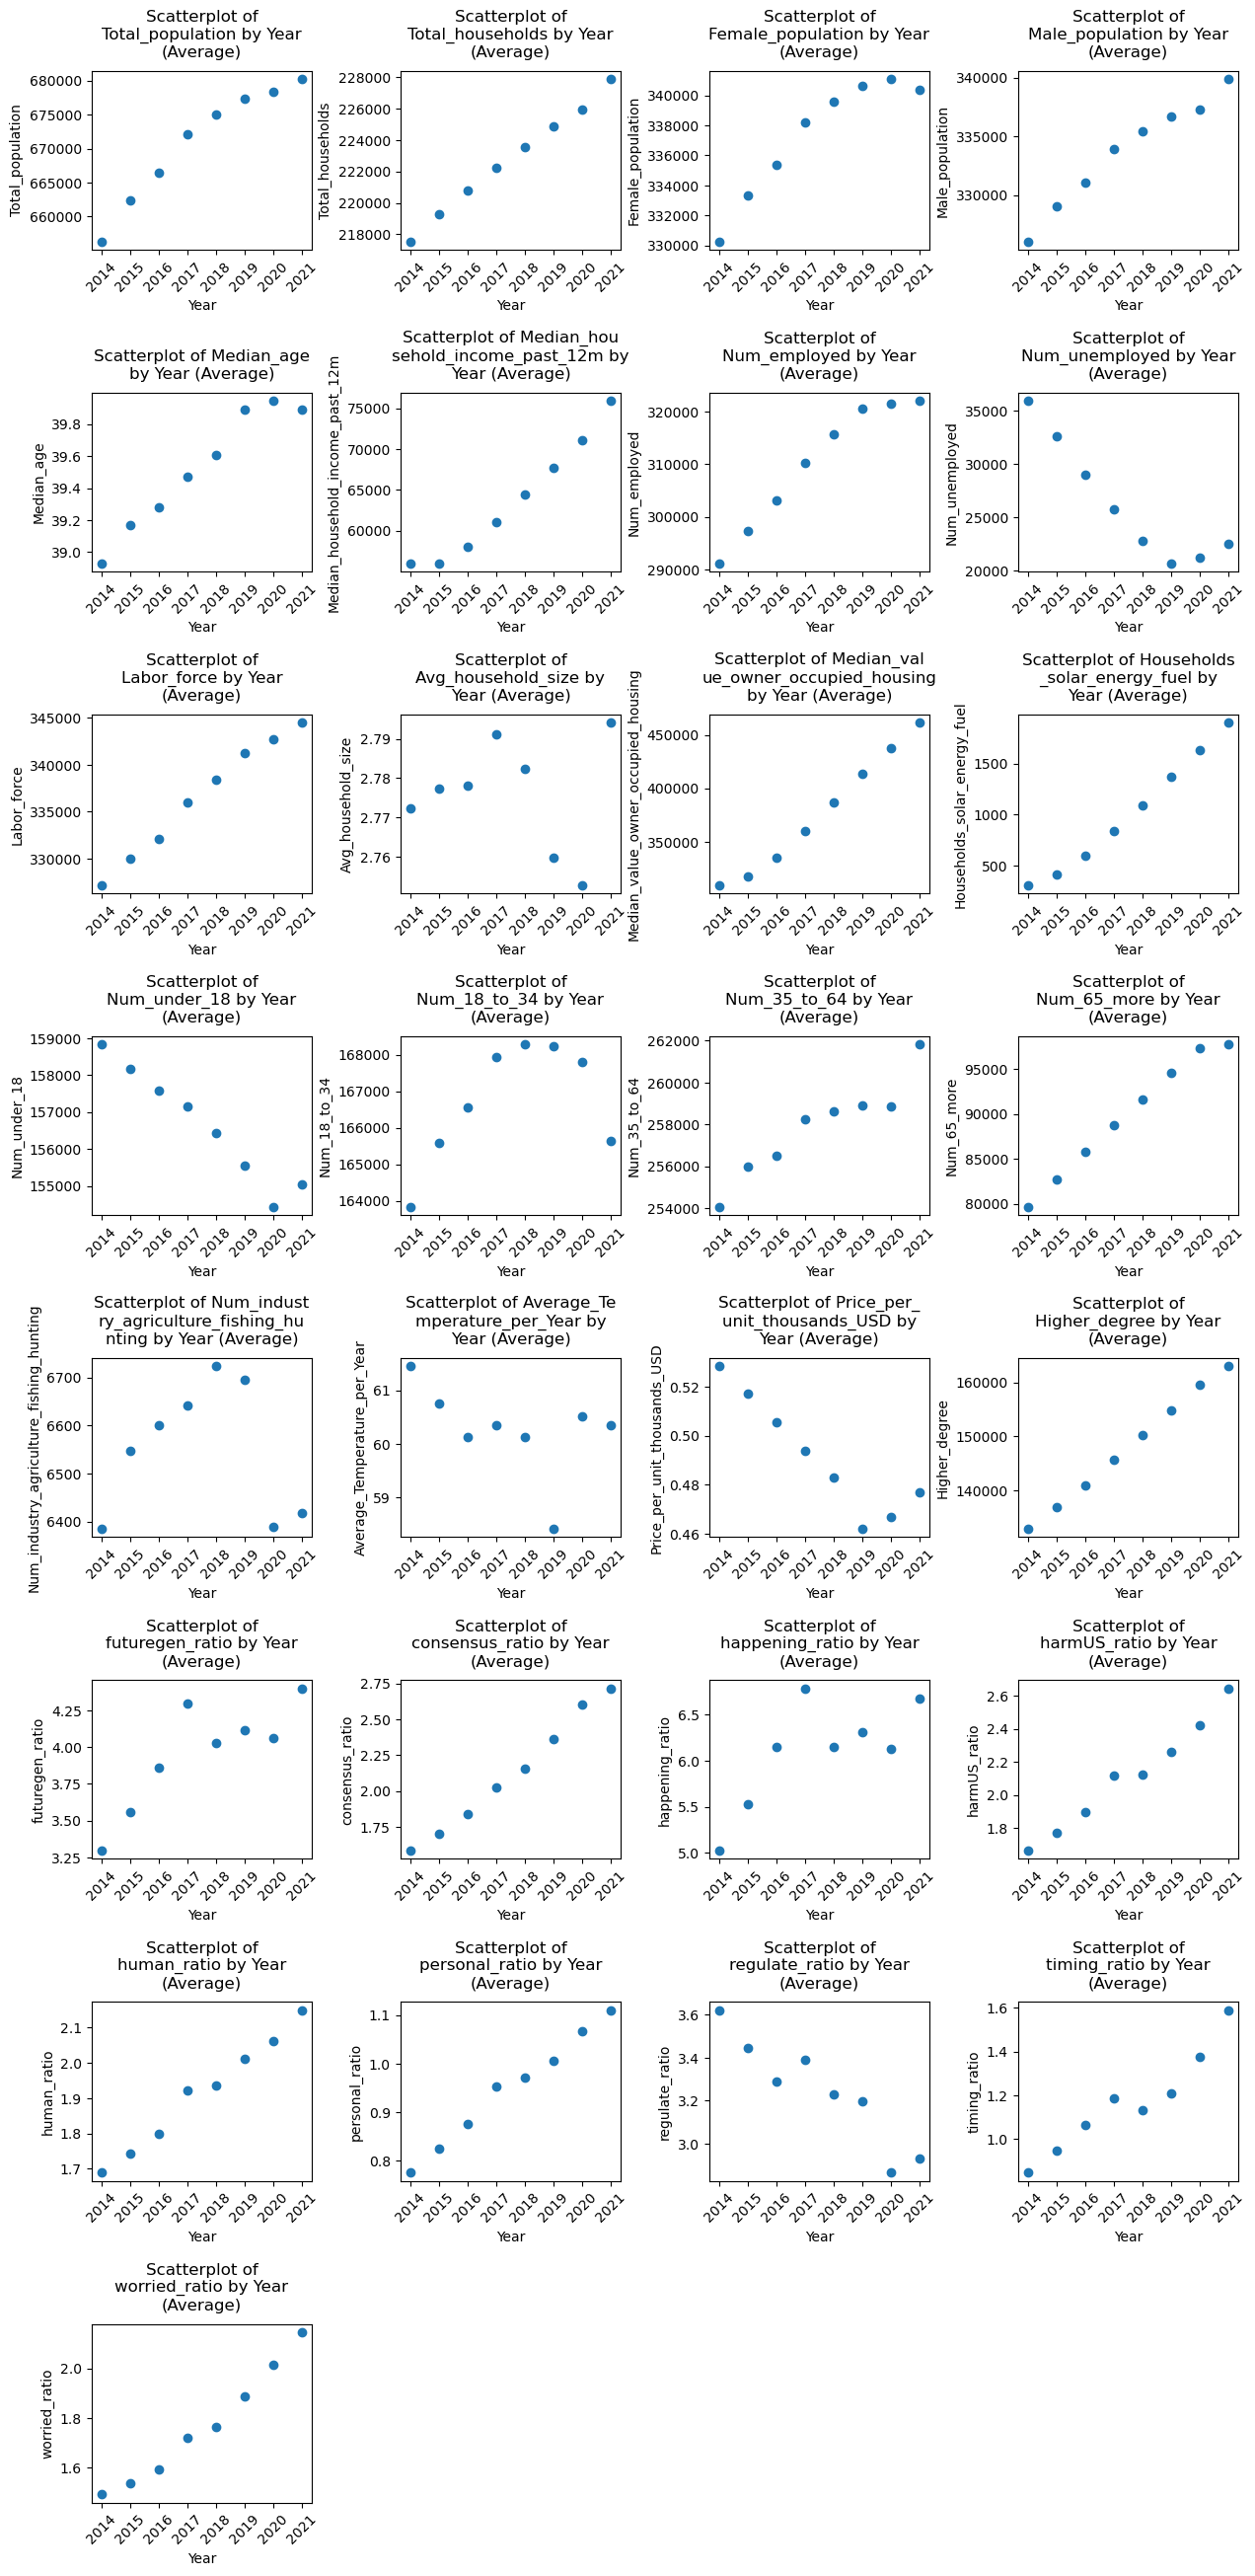

In [15]:
num_cols = 4  

# Create subplots
num_rows = math.ceil(len(predictor_vars) / num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4*num_rows))

# Scatterplots with average per year
for i, predictor in enumerate(predictor_vars):
    row = i // num_cols
    col = i % num_cols
    
    axes[row, col].scatter(df_grouped['Year'], df_grouped[predictor])
    axes[row, col].set_xlabel('Year')
    axes[row, col].set_ylabel(predictor)
    
    # Wrap the title to multiple lines if necessary
    title = f'Scatterplot of {predictor} by Year (Average)'
    wrapped_title = "\n".join(textwrap.wrap(title, width=25)) 
    
    axes[row, col].set_title(wrapped_title, pad=10)  
    axes[row, col].tick_params(axis='x', rotation=45) 

# Remove any empty subplots
if len(predictor_vars) % num_cols != 0:
    empty_subplots = num_cols - (len(predictor_vars) % num_cols)
    for i in range(1, empty_subplots+1):
        fig.delaxes(axes[-1, -i])

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.8) 

# Display the subplots
plt.show();

## assumption 2: normality

In [16]:
X = df_final.drop(columns=['Revenue_by_county_Million'])
y = df_final['Revenue_by_county_Million']

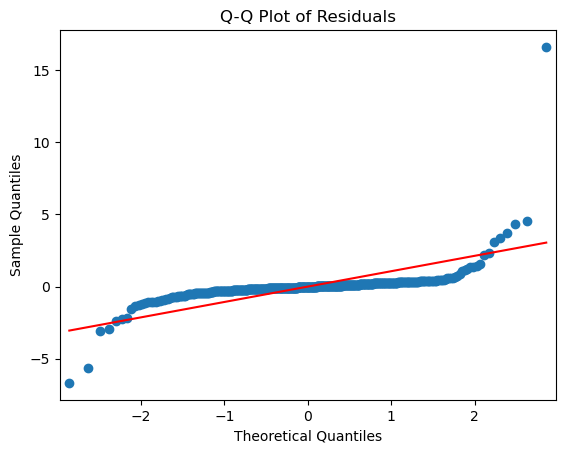

In [17]:
# Add a constant column to the predictor variables for the intercept term
X = sm.add_constant(X)

# Fit the multiple regression model
model = sm.OLS(y, X).fit()

# Extract residuals 
residuals = model.resid

# Check normality assumption using Q-Q plot
sm.qqplot(residuals, line='s')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot of Residuals')
plt.show();


## Assumption 3: Homoscedasticity

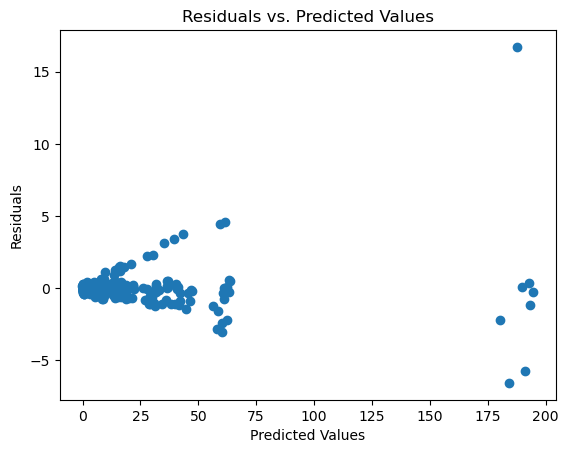

In [18]:
X = df_final.drop(columns=['Revenue_by_county_Million'])
# Fit the multiple regression model and get the residuals
model = sm.OLS(y, X).fit()
residuals = model.resid

# Homoscedasticity check - Residuals vs. Predicted values scatterplot
plt.scatter(model.predict(), residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show();

In [19]:
# Goldfeld-Quandt Test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(y, X)
lzip(name, test)

[('F statistic', 0.007792314660827381), ('p-value', 0.9999999999999999)]

## Assumption 4: Independence

In [20]:
# Independence check - Durbin-Watson test
dw_test = sm.stats.stattools.durbin_watson(residuals)
print('Durbin-Watson test statistic:', dw_test)

Durbin-Watson test statistic: 1.5203406805855373


When interpreting the Durbin-Watson test statistic:
* A value close to 0 indicates strong positive autocorrelation.
* A value close to 2 suggests no autocorrelation (ideal case).
* A value close to 4 suggests strong negative autocorrelation.

In your scenario, the test statistic of 1.52 suggests some positive autocorrelation but does not indicate a severe violation of the independence assumption. 